In [1]:
# import package needed
%matplotlib inline
import matplotlib.pyplot as plt
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"  # this line make pop-out window not appear
import numpy as np
from ple.games.flappybird import FlappyBird
from ple import PLE

game = FlappyBird()
env = PLE(game, fps=30, display_screen=False)  # environment interface to game
env.reset_game()

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html
couldn't import doomish
Couldn't import doom


In [2]:
# return a dictionary whose key is action description and value is action index
print(game.actions)
# return a list of action index (include None)
print(env.getActionSet())

{'up': 119}
[119, None]


In [3]:
game.getGameState()  # a dictionary describe state

{'player_y': 256,
 'player_vel': 0,
 'next_pipe_dist_to_player': 309.0,
 'next_pipe_top_y': 144,
 'next_pipe_bottom_y': 244,
 'next_next_pipe_dist_to_player': 453.0,
 'next_next_pipe_top_y': 160,
 'next_next_pipe_bottom_y': 260}

In [4]:
import math
import copy
from collections import defaultdict
MIN_EXPLORING_RATE = 0.01
MIN_LEARNING_RATE = 0.5


class Agent:

  def __init__(self,
               bucket_range_per_feature,
               num_action,
               t=0,
               discount_factor=0.99):
    self.update_parameters(t)  # init explore rate and learning rate
    self.q_table = defaultdict(lambda: np.zeros(num_action))
    self.discount_factor = discount_factor
    self.num_action = num_action

    # how to discretize each feature in a state
    # the higher each value, less time to train but with worser performance
    # e.g. if range = 2, feature with value 1 is equal to feature with value 0 bacause int(1/2) = int(0/2)
    self.bucket_range_per_feature = bucket_range_per_feature

  def select_action(self, state):
    # epsilon-greedy
    state_idx = self.get_state_idx(state)
    if np.random.rand() < self.exploring_rate:
      action = np.random.choice(num_action)  # Select a random action
    else:
      action = np.argmax(
          self.q_table[state_idx])  # Select the action with the highest q
    return action

  def update_policy(self, state, action, reward, action_prime, state_prime):
    state_idx = self.get_state_idx(state)
    state_prime_idx = self.get_state_idx(state_prime)
    # Update Q_value using Q-learning update rule
    # best_q = np.max(self.q_table[state_prime_idx])
    
    best_q = self.q_table[state_prime_idx][action_prime]
    self.q_table[state_idx][action] += self.learning_rate * (
        reward + self.discount_factor * best_q - self.q_table[state_idx][action])

  def get_state_idx(self, state):
    # instead of using absolute position of pipe, use relative position
    state = copy.deepcopy(state)
    state['next_next_pipe_bottom_y'] -= state['player_y']
    state['next_next_pipe_top_y'] -= state['player_y']
    state['next_pipe_bottom_y'] -= state['player_y']
    state['next_pipe_top_y'] -= state['player_y']

    # sort to make list converted from dict ordered in alphabet order
    state_key = [k for k, v in sorted(state.items())]

    # do bucketing to decrease state space to speed up training
    state_idx = []
    for key in state_key:
      state_idx.append(int(state[key] / self.bucket_range_per_feature[key]))
    return tuple(state_idx)

  def update_parameters(self, episode):
    self.exploring_rate = max(MIN_EXPLORING_RATE,
                              min(0.5, 0.99**((episode) / 30)))
    self.learning_rate = max(MIN_LEARNING_RATE, min(0.5, 0.99
                                                    **((episode) / 30)))

  def shutdown_explore(self):
    # make action selection greedy
    self.exploring_rate = 0

In [5]:
num_action = len(env.getActionSet())
bucket_range_per_feature = {
  'next_next_pipe_bottom_y': 40,
  'next_next_pipe_dist_to_player': 512,
  'next_next_pipe_top_y': 40,
  'next_pipe_bottom_y': 20,
  'next_pipe_dist_to_player': 20,
  'next_pipe_top_y': 20,
  'player_vel': 4,
  'player_y': 16
}
# init agent
agent = Agent(bucket_range_per_feature, num_action)

In [6]:
def make_anim(images, fps=60, true_image=False):
  duration = len(images) / fps
  import moviepy.editor as mpy

  def make_frame(t):
    try:
      x = images[int(len(images) / duration * t)]
    except:
      x = images[-1]

    if true_image:
      return x.astype(np.uint8)
    else:
      return ((x + 1) / 2 * 255).astype(np.uint8)

  clip = mpy.VideoClip(make_frame, duration=duration)
  clip.fps = fps
  return clip

In [7]:
from IPython.display import Image, display

reward_per_epoch = []
lifetime_per_epoch = []
exploring_rates = []
learning_rates = []
print_every_episode = 500
show_gif_every_episode = 5000
NUM_EPISODE = 30000
for episode in range(0, NUM_EPISODE):

  # Reset the environment
  env.reset_game()

  # record frame
  frames = [env.getScreenRGB()]

  # for every 500 episodes, shutdown exploration to see performance of greedy action
  if episode % print_every_episode == 0:
    agent.shutdown_explore()

  # the initial state
  state = game.getGameState()
  cum_reward = 0  # cumulate reward for this episode
  t = 0
  # select an action
  action = agent.select_action(state)
    

  while not env.game_over():

    # execute the action and get reward
    reward = env.act(
        env.getActionSet()[action])  # reward = +1 when pass a pipe, -5 when die

    frames.append(env.getScreenRGB())

    # cumulate reward
    cum_reward += reward

    # observe the result
    state_prime = game.getGameState()  # get next state

    action_prime = agent.select_action(state_prime)
    # update agent
    agent.update_policy(state, action, reward, action_prime,state_prime)

    # Setting up for the next iteration
    state = state_prime
    t += 1
    
    action = action_prime
  # update exploring_rate and learning_rate
  agent.update_parameters(episode)

  if episode % print_every_episode == 0:
    print("Episode %d finished after %f time steps" % (episode, t))
    print("cumulated reward: %f" % cum_reward)
    print("exploring rate %f" % agent.exploring_rate)
    print("learning rate %f" % agent.learning_rate)
    reward_per_epoch.append(cum_reward)
    exploring_rates.append(agent.exploring_rate)
    learning_rates.append(agent.learning_rate)
    lifetime_per_epoch.append(t)

  # for every 5000 episode, record an animation
  if episode % show_gif_every_episode == 0:
    print("len frames:", len(frames))
    clip = make_anim(frames, fps=60, true_image=True).rotate(-90)
    display(clip.ipython_display(fps=60, autoplay=1, loop=1))

  0%|          | 0/64 [00:00<?, ?it/s]

Episode 0 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.500000
learning rate 0.500000
len frames: 63


 98%|█████████▊| 63/64 [00:00<00:00, 189.54it/s]


Episode 500 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.500000
learning rate 0.500000
Episode 1000 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.500000
learning rate 0.500000
Episode 1500 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.500000
learning rate 0.500000
Episode 2000 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.500000
learning rate 0.500000
Episode 2500 finished after 60.000000 time steps
cumulated reward: -5.000000
exploring rate 0.432779
learning rate 0.500000
Episode 3000 finished after 63.000000 time steps
cumulated reward: -5.000000
exploring rate 0.366032
learning rate 0.500000
Episode 3500 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.309580
learning rate 0.500000
Episode 4000 finished after 63.000000 time steps
cumulated reward: -5.000000
exploring rate 0.261834
learning rate 0.500000
Episode 4

 27%|██▋       | 17/64 [00:00<00:00, 163.70it/s]

Episode 5000 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.187298
learning rate 0.500000
len frames: 63


 98%|█████████▊| 63/64 [00:00<00:00, 190.96it/s]


Episode 5500 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.158411
learning rate 0.500000
Episode 6000 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.133980
learning rate 0.500000
Episode 6500 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.113316
learning rate 0.500000
Episode 7000 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.095840
learning rate 0.500000
Episode 7500 finished after 98.000000 time steps
cumulated reward: -4.000000
exploring rate 0.081059
learning rate 0.500000
Episode 8000 finished after 45.000000 time steps
cumulated reward: -5.000000
exploring rate 0.068557
learning rate 0.500000
Episode 8500 finished after 71.000000 time steps
cumulated reward: -4.000000
exploring rate 0.057984
learning rate 0.500000
Episode 9000 finished after 70.000000 time steps
cumulated reward: -4.000000
exploring rate 0.049041
learning rate 0.500000
Episode 

 12%|█▏        | 9/73 [00:00<00:00, 87.14it/s]

Episode 10000 finished after 71.000000 time steps
cumulated reward: -4.000000
exploring rate 0.035080
learning rate 0.500000
len frames: 72


 99%|█████████▊| 72/73 [00:00<00:00, 108.07it/s]


Episode 10500 finished after 211.000000 time steps
cumulated reward: -1.000000
exploring rate 0.029670
learning rate 0.500000
Episode 11000 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.025094
learning rate 0.500000
Episode 11500 finished after 74.000000 time steps
cumulated reward: -4.000000
exploring rate 0.021224
learning rate 0.500000
Episode 12000 finished after 98.000000 time steps
cumulated reward: -4.000000
exploring rate 0.017951
learning rate 0.500000
Episode 12500 finished after 134.000000 time steps
cumulated reward: -3.000000
exploring rate 0.015182
learning rate 0.500000
Episode 13000 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.012841
learning rate 0.500000
Episode 13500 finished after 401.000000 time steps
cumulated reward: 4.000000
exploring rate 0.010860
learning rate 0.500000
Episode 14000 finished after 98.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.50000

 10%|▉         | 19/191 [00:00<00:00, 188.15it/s]

Episode 15000 finished after 189.000000 time steps
cumulated reward: -1.000000
exploring rate 0.010000
learning rate 0.500000
len frames: 190


 99%|█████████▉| 190/191 [00:00<00:00, 239.45it/s]


Episode 15500 finished after 134.000000 time steps
cumulated reward: -3.000000
exploring rate 0.010000
learning rate 0.500000
Episode 16000 finished after 76.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500000
Episode 16500 finished after 272.000000 time steps
cumulated reward: 1.000000
exploring rate 0.010000
learning rate 0.500000
Episode 17000 finished after 134.000000 time steps
cumulated reward: -3.000000
exploring rate 0.010000
learning rate 0.500000
Episode 17500 finished after 134.000000 time steps
cumulated reward: -3.000000
exploring rate 0.010000
learning rate 0.500000
Episode 18000 finished after 340.000000 time steps
cumulated reward: 3.000000
exploring rate 0.010000
learning rate 0.500000
Episode 18500 finished after 98.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500000
Episode 19000 finished after 132.000000 time steps
cumulated reward: -3.000000
exploring rate 0.010000
learning rate 0.500

 14%|█▍        | 14/100 [00:00<00:00, 139.14it/s]

Episode 20000 finished after 98.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500000
len frames: 99


 99%|█████████▉| 99/100 [00:00<00:00, 200.76it/s]


Episode 20500 finished after 247.000000 time steps
cumulated reward: 0.000000
exploring rate 0.010000
learning rate 0.500000
Episode 21000 finished after 134.000000 time steps
cumulated reward: -3.000000
exploring rate 0.010000
learning rate 0.500000
Episode 21500 finished after 218.000000 time steps
cumulated reward: 0.000000
exploring rate 0.010000
learning rate 0.500000
Episode 22000 finished after 98.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500000
Episode 22500 finished after 360.000000 time steps
cumulated reward: 3.000000
exploring rate 0.010000
learning rate 0.500000
Episode 23000 finished after 858.000000 time steps
cumulated reward: 17.000000
exploring rate 0.010000
learning rate 0.500000
Episode 23500 finished after 301.000000 time steps
cumulated reward: 2.000000
exploring rate 0.010000
learning rate 0.500000
Episode 24000 finished after 190.000000 time steps
cumulated reward: -1.000000
exploring rate 0.010000
learning rate 0.5000

  0%|          | 1/249 [00:00<00:28,  8.78it/s]

Episode 25000 finished after 247.000000 time steps
cumulated reward: 0.000000
exploring rate 0.010000
learning rate 0.500000
len frames: 248


100%|██████████| 249/249 [00:02<00:00, 86.14it/s]


Episode 25500 finished after 288.000000 time steps
cumulated reward: 1.000000
exploring rate 0.010000
learning rate 0.500000
Episode 26000 finished after 247.000000 time steps
cumulated reward: 0.000000
exploring rate 0.010000
learning rate 0.500000
Episode 26500 finished after 550.000000 time steps
cumulated reward: 8.000000
exploring rate 0.010000
learning rate 0.500000
Episode 27000 finished after 393.000000 time steps
cumulated reward: 4.000000
exploring rate 0.010000
learning rate 0.500000
Episode 27500 finished after 247.000000 time steps
cumulated reward: 0.000000
exploring rate 0.010000
learning rate 0.500000
Episode 28000 finished after 134.000000 time steps
cumulated reward: -3.000000
exploring rate 0.010000
learning rate 0.500000
Episode 28500 finished after 514.000000 time steps
cumulated reward: 7.000000
exploring rate 0.010000
learning rate 0.500000
Episode 29000 finished after 2322.000000 time steps
cumulated reward: 55.000000
exploring rate 0.010000
learning rate 0.5000

In [8]:
def demo():
  # Reset the environment
  env.reset_game()

  # record frame
  frames = [env.getScreenRGB()]

  # for every 500 episodes, shutdown exploration to see performance of greedy action
  agent.shutdown_explore()

  # the initial state
  state = game.getGameState()

  while not env.game_over():
    # select an action
    action = agent.select_action(state)

    # execute the action and get reward
    reward = env.act(env.getActionSet()[action])

    frames.append(env.getScreenRGB())

    # observe the result
    state_prime = game.getGameState()  # get next state

    # Setting up for the next iteration
    state = state_prime

  clip = make_anim(frames, fps=60, true_image=True).rotate(-90)
  display(clip.ipython_display(fps=60, autoplay=1, loop=1))
demo()

100%|█████████▉| 891/892 [00:04<00:00, 204.80it/s]


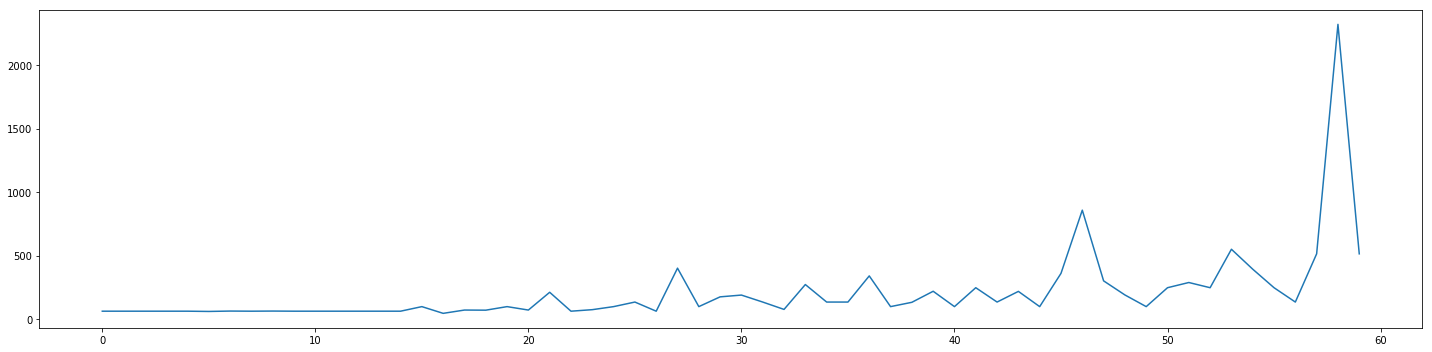

In [9]:
# plot life time against training episodes
fig, ax1 = plt.subplots(figsize=(20, 5))
plt.plot(range(len(lifetime_per_epoch)), lifetime_per_epoch)
fig.tight_layout()
plt.show()

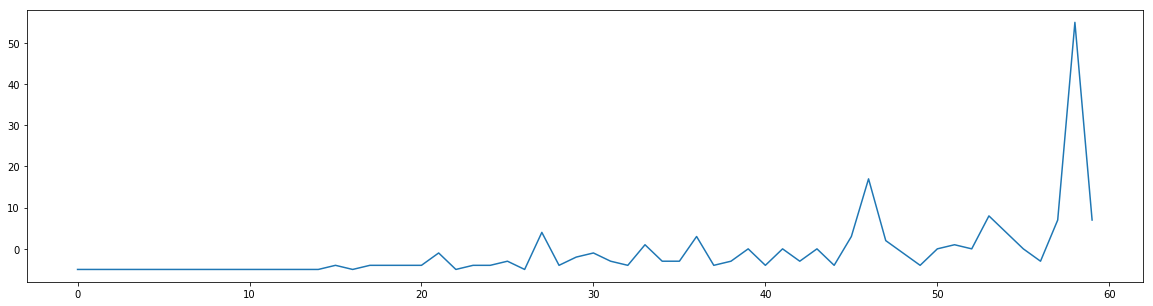

In [10]:
# plot reward against training episodes
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(20, 5))
plt.plot(range(len(reward_per_epoch)), reward_per_epoch)
plt.show()

qlearning
![](https://i.imgur.com/TLJnlQG.png)


Discuss:
The policy difference between sarsa and q learning is that the agent in SARSA interacts with the environment and updates the policy based on actions taken, however q-learning assume that the it is following an optimal solution.

From the plot of Sarsa and Q learning, we can see that sarsa computes slower than q learning but from the final result we can see that it generates better results than Q learning since it takes more into account.